## Decoder-only architecture - GPT2

## 1. Introduction

For this exercise, we will focus on **decoder-only models**, particularly **GPT-2** (Generative Pre-trained Transformer 2), a model designed for text generation.

#### **Decoder-Only Models**
Decoder-only models, like GPT-2, differ from encoder-decoder models in that they generate text in a **unidirectional (left-to-right)** manner. These models do not have an encoder to process the entire input at once. Instead, they use **autoregressive** generation, predicting the next token based on the preceding context.

For the part of this lab, we will use `GPT2LMHeadModel`, a GPT-2 model with a language modeling head.

In [1]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# Load GPT-2 tokenizer and model
model_name = 'gpt2'  
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

model

/home/csavelli/llm/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### 1. **Embeddings Layer**
The embeddings layer creates initial representations of the input tokens, encoding both the meaning of the words and their positions within the sequence.

- **Word Embeddings** (`wte`): Maps each of the 50,257 vocabulary tokens into a 768-dimensional vector space.
- **Position Embeddings** (`wpe`): Adds positional information to the tokens using a learned embedding of size 1024 (representing the maximum sequence length) with 768 dimensions. This allows the model to understand the order of the tokens, as transformers do not have an inherent sense of position.

### 2. **Transformer Block (Decoder)**
The core of GPT-2 is composed of 12 identical **transformer blocks**, each consisting of several sub-components. These blocks are stacked to process the input text in a sequential, autoregressive manner.

Each transformer block includes the following:

- **Layer Normalization (ln_1, ln_2)**: Normalization is applied before both the attention mechanism and the feed-forward network to stabilize and speed up training. It ensures that the inputs to the layers have the same mean and variance, using learned parameters.

- **Self-Attention Mechanism**

  - **Self-Attention Mechanism (attn)**: GPT-2 uses masked self-attention to ensure that the model can only attend to tokens that have already been processed, preventing the model from "seeing" future tokens. This makes the model autoregressive.
    
    - **Query, Key, Value Projections**: The attention mechanism computes the **query (Q)**, **key (K)**, and **value (V)** vectors using **Conv1D layers** (`c_attn`). Notice that (1) when the kernel size is 1, the role of Conv1d is just to do a linear projection, and (2) that under the hood, the Conv1d used in HuggingFace is indeed just a linear projection (see code [here](https://github.com/huggingface/transformers/blob/53fad641cfdb5105e2470bcf3ef17ea8e25cc300/src/transformers/pytorch_utils.py#L87)). In other words, `c_attn` performs a linear transformation and covers the role of $W_q$, $W_k$, and $W_v$. All other operations using Conv1d will follow the same principle.

    - **Attention Output**: The output of the attention layer is passed through another **Conv1D layer** (`c_proj`) to project it back to the original 768-dimensional space.

- **Feed-Forward Neural Network (mlp)**
Each transformer block also contains a fully connected feed-forward neural network that processes the output of the attention mechanism. This is done in two stages:

  - **First Linear Transformation (`c_fc`)**: Expands the dimensionality from 768 to a larger intermediate size using a **Conv1D layer**.
    
  - **Activation Function (`act`)**: Applies the **GELU (Gaussian Error Linear Unit)** activation function, which introduces non-linearity and helps the model capture complex patterns in the data.

  - **Second Linear Transformation (`c_proj`)**: Projects the output back down from the intermediate size to 768 dimensions using another **Conv1D layer**.

- **Residual Connections**
  - GPT-2 uses skip connections around both the self-attention and feed-forward layers, where the input to each sub-layer is added to its output.

### 3. **Final Layer Normalization and Language Modeling Head**
- After passing through all 12 transformer blocks, a final **LayerNorm** (`ln_f`) is applied to normalize the output before it is passed to the language modeling head for token prediction.

- The output of the final transformer block is passed through a **linear layer** (`lm_head`) which maps the 768-dimensional hidden states to the vocabulary size (50,257). This step is essential for converting the hidden representations into predictions for the next token in the sequence.


In [2]:
# Set the model to evaluation mode
model.eval()

# Define the input prompt
prompt = "I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair."

# Tokenize the input prompt
input_ids = tokenizer.encode(prompt, return_tensors='pt')

# Autoregressively generate tokens 
generated_ids = model.generate(input_ids.to(device), max_length=200, do_sample=True, temperature=1.1)

# Decode and print the generated text
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print("Generated Text:")
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated Text:
I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair. His complexion consisted of a dark scarlet, brownish fur, and a little pointed nose; he wore dark trousers, a hat, and, above all, a very low mop of hair. They were well dressed, as though he had spent some time in the garden of the most comfortable home where there was something in common here. Indeed I could not imagine at all how he was to respond to my enquiry. Yet he always spoke with a tone of great conviction when spoken with confidence, and I do not know why he spoke so little about his own interests and his own friend. I knew, though, that Mr. Holmes had some strange friend, one of whom I regarded the whole of the family with most curiosity, and perhaps his own personal interest. The man


## 2. Decoder (Masked) Self-Attention Mechanism

In this exercise, we will focus on the **masked self-attention mechanism** used in the decoder blocks of GPT-2. This mechanism allows the model to attend to previous tokens in an autoregressive manner, ensuring that the model generates text sequentially from left to right without looking ahead to future tokens.

A plot of the **self-attention matrix** for a single decoder block in GPT-2 is shown below. The matrix represents the attention weights between different tokens in the input sequence. The **x-axis** and **y-axis** correspond to the tokens in the input sequence. Each position on these axes represents a specific token in the input text.
  
#### **Masked Self-Attention Behavior:**
- As expected in a **decoder-only** model, we observe a clear triangular pattern. Tokens only attend to themselves and the tokens that precede them. For example, the first token (`I`) only attends to itself, the second token (`love`) attends to both itself and the first token, and so on.
- The upper-right part of the matrix is empty (dark purple), indicating that the model **masks future tokens** to prevent them from being used in generating the current token. This ensures that GPT-2 maintains its **autoregressive property**, where each token is generated based only on past tokens.

- In the image, you can see that certain tokens attend more strongly to previous tokens. For example, the token `favorite` attends heavily to earlier tokens like `Italian` and `food`, as indicated by the brighter colors in the heatmap.
- The model tends to attend more to the recent past tokens, which is crucial for maintaining context during text generation.


`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


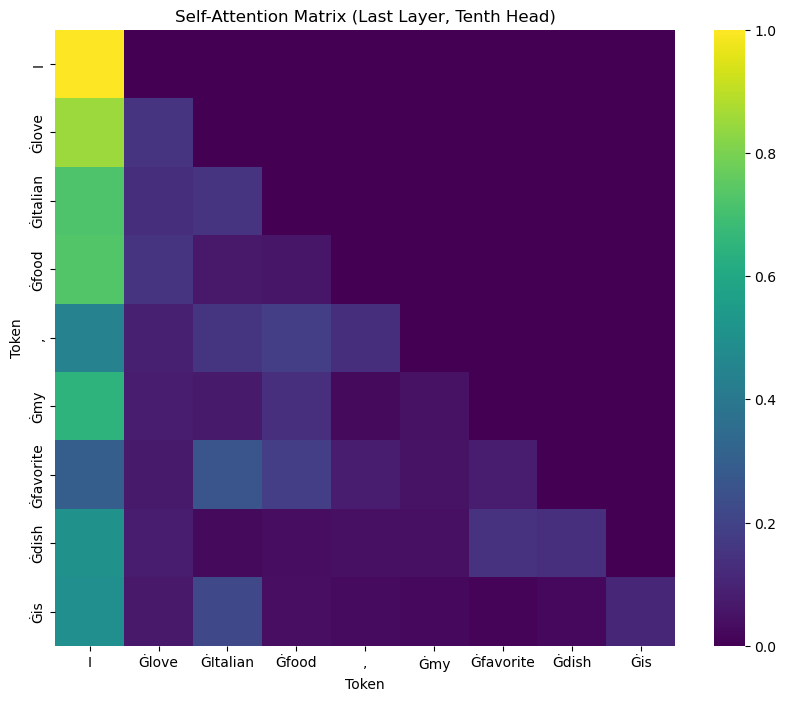

In [3]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import matplotlib.pyplot as plt
import seaborn as sns

model_name = 'gpt2'  # Assicurati di avere il nome del modello corretto
model = GPT2Model.from_pretrained(model_name, output_attentions=True).to(device)

# Input prompt
prompt = "I love Italian food, my favorite dish is"

# Tokenize the input prompt
inputs = tokenizer(prompt, return_tensors='pt').to(device)

# Generate the model output and retrieve attention weights
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  # List of attention matrices from all layers

# Visualize the attention weights from the last layer
attention_matrix = attentions[-1][0][10].cpu().numpy()  # Last layer, first head

# Get the tokens for the input prompt
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Plot the attention matrix (last layer, first head) with words as labels
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.title('Self-Attention Matrix (Last Layer, Tenth Head)')
plt.xlabel('Token')
plt.ylabel('Token')
plt.show()

## 3. Positional Embedding

Similarly to what we have seen in the previous exercise (`01-bert`), GPT-2 uses **positional embeddings** to encode the position of tokens in the input sequence. These embeddings are added to the token embeddings to provide the model with information about the order of the tokens. 

Also in GPT-2, the positional embeddings are learned during training, allowing the model to capture complex patterns in the data.

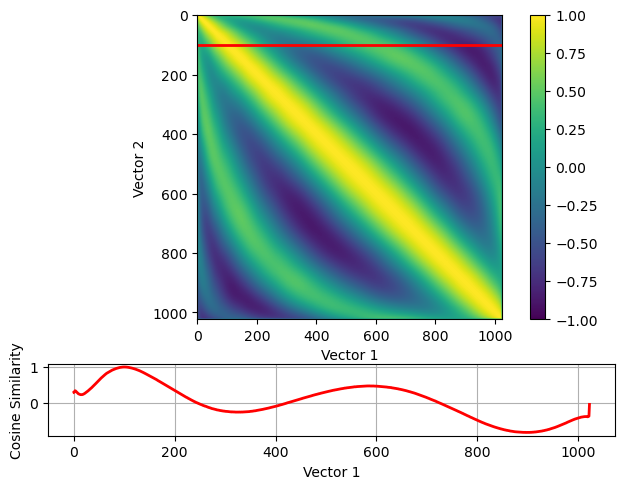

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Extract learned positional embeddings from the model
positional_embeddings = model.wpe.weight.detach().cpu().numpy()  # Shape: (1024, 768)

# Compute cosine similarity between positional embeddings
cosine_sim = cosine_similarity(positional_embeddings)

fig, ax = plt.subplot_mosaic("""
AAA
AAA
AAA
BBB""")

plt.tight_layout()

# Plot the cosine similarity heatmap
ax["A"].set_aspect('equal')
cbar = ax["A"].imshow(cosine_sim, cmap='viridis', vmin=-1, vmax=1)
ax["A"].set_xlabel('Vector 1')
ax["A"].set_ylabel('Vector 2')
ax["A"].axhline(100, c='r', lw=2)
# add colorbar
fig.colorbar(cbar, ax=ax["A"])


# Plot the cosine similarity for a specific row

ax["B"].plot(cosine_sim[100], c='r', lw=2)
ax["B"].set_xlabel('Vector 1')
ax["B"].set_ylabel('Cosine Similarity')
ax["B"].grid()

## 4. Sampling Methods

### **Implementing Sampling Methods:**

In this exercise, we will explore various **sampling methods** used for text generation in GPT-2. Each sampling method determines how the model selects the next token when generating text. 

GPT-2 produces a probability distribution over possible tokens for each position in the sequence. The different sampling strategies allow us to choose how we sample from this distribution.

In [6]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained GPT-2 model and tokenizer
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

# Set the pad token to eos token
tokenizer.pad_token = tokenizer.eos_token

# Set the model to evaluation mode
model.eval()

# Input prompt
prompt = "I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair."

# Tokenize the input prompt
inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True)

1. **Greedy Sampling**: Always selects the token with the highest probability at each step.

In [7]:
# Greedy Sampling: Pick the token with the highest probability
def greedy_sampling(model, input_ids, max_length):
    input_ids = input_ids.to(device)
    for _ in range(max_length):
        # NOTE: There's no need to pass an attention mask, since we are passing a single
        # input sequence and the model will automatically create the mask.
        logits = model(input_ids=input_ids).logits[:, -1, :] # Compute the logits for the last token (1st batch)
        next_token = torch.argmax(logits, dim=1).unsqueeze(1) # Get the most likely next token
        input_ids = torch.hstack([input_ids, next_token]) # Add the token to the output sequence

        if next_token.item() == tokenizer.eos_token_id:
            break

    return input_ids

# Generate and return text using each sampling method
max_length = 100  # Max tokens to generate

# Greedy Sampling
input_length = inputs["input_ids"].shape[-1]
output_greedy = greedy_sampling(model, input_ids, max_length)
print(prompt)
print(tokenizer.decode(output_greedy[0, input_length:], skip_special_tokens=True))

I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair.
 He was a very handsome man, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was


2. **Beam Search**: Expands multiple candidate sequences and selects the best based on their cumulative probabilities.

In [8]:
# Beam Search (simple version with fixed beam width)

# NOTE: each score is the log-probability of the sequence
# (remember, the sum of log-probabilities is the log-probability of the product)
# (i.e., of the entire sentence)
def beam_search(model, input_ids, max_length, beam_width=3):
    sequences = [(input_ids.to(device), 0)]  # (sequence, score)
    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            logits = model(seq).logits[:, -1, :]

            probs = F.softmax(logits, dim=-1)
            top_k_probs, top_k_tokens = torch.topk(probs, beam_width, dim=-1) # Get top k tokens

            for i in range(beam_width):
                candidate_seq = torch.cat([seq, top_k_tokens[:, i].unsqueeze(-1)], dim=-1)  # Add token to sequence
                candidate = (candidate_seq, score - torch.log(top_k_probs[:, i]).item()) # Update score by adding -log(prob)
                all_candidates.append(candidate) # Add new candidate

        # Select top `beam_width` sequences
        sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_width]

        if sequences[0][0][0, -1].item() == tokenizer.eos_token_id:
            break
        
    return sequences[0][0]

# Beam Search
output_beam = beam_search(model, input_ids, max_length, beam_width=5)
print(prompt)
print(tokenizer.decode(output_beam[0, input_length:], skip_special_tokens=True))


I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair.
 He told me that he had come to see me, and that he had come to see me for the first time in a long time. He told me that he had come to see me for the first time in a long time. He told me that he had come to see me for the first time in a long time. He told me that he had come to see me for the first time in a long time. He told me that he had come to see me for the first time in


3. **Random Sampling**: Samples tokens randomly according to their probabilities.

In [9]:
# Random Sampling: Randomly sample a token from the distribution
def random_sampling(model, input_ids, max_length):
    output = input_ids.to(device)
    for _ in range(max_length):
        logits = model(output).logits[:, -1, :]
        
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)  # Sample a token from the probability distribution produced by the model

        output = torch.cat([output, next_token], dim=-1)

        if next_token.item() == tokenizer.eos_token_id:
            break

    return output

# Random Sampling
output_random = random_sampling(model, input_ids, max_length)
print(prompt)
print(tokenizer.decode(output_random[0, input_length:], skip_special_tokens=True))


I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair.
 He was about ninety-three years old, and now he showed virtually no interest as a patient. He sounded as nervous as usual, and I became aware that Dr. Holmes certainly would not be half as amused by him as she. I went to ask him whether he would bring a wand in Sheffield or any other architectural subject. He replied that he had consulted us years ago; at times of great worry we suspected that he was lying; sometimes succeeding men in the business of writing, and most of


4. **Top-k Sampling**: Samples only from the top `k` most probable tokens.

In [10]:
# Top-k Sampling: Sample from the top k tokens
def top_k_sampling(model, input_ids, max_length, k=50):
    output = input_ids.to(device)
    for _ in range(max_length):
        logits = model(output).logits[:, -1, :]

        top_k_logits, top_k_tokens = torch.topk(logits, k, dim=-1)
        top_k_probs = F.softmax(top_k_logits, dim=-1)

        sampled_index = torch.multinomial(top_k_probs, num_samples=1)
        next_token = top_k_tokens[0, sampled_index] # Select the sampled token

        output = torch.cat([output, next_token], dim=-1)

        if next_token.item() == tokenizer.eos_token_id:
            break
        
    return output

# Top-k Sampling
output_top_k = top_k_sampling(model, input_ids, max_length, k=50)
print(prompt)
print(tokenizer.decode(output_top_k[0, input_length:], skip_special_tokens=True))


I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair.
 He was telling us a story of his youth and he could not help but say that his friend was only about four years old, who had, as he went on to lecture and write, taken to work hard and who was at the time also a very successful merchant.

It was a very odd time for him, but it was no bad one. In fact some of his favourite anecdotes had come out of it and were very illuminating. I found the man very kind and charming. It turned


5. **Top-p (Nucleus) Sampling**: Samples from the smallest set of tokens whose cumulative probability exceeds `p`.

In [11]:
# Top-p (Nucleus) Sampling: Sample from the smallest set of tokens whose cumulative probability exceeds p
def top_p_sampling(model, input_ids, max_length, p=0.9):
    output = input_ids.to(device)
    for _ in range(max_length):
        logits = model(output).logits[:, -1, :]
        
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1) # Cumulative Distribution Function (CDF)
        top_p_indices = cumulative_probs <= p

        if top_p_indices.sum() == 0:  # Fix for when there are no valid top-p indices
            top_p_indices[0] = True  # Ensure at least one token is considered

        top_p_probs = F.softmax(sorted_logits[top_p_indices], dim=-1) # Recompute the probabilities
        sampled_index = torch.multinomial(top_p_probs, num_samples=1) # Sample from the updated distribution

        next_token = sorted_indices[top_p_indices][sampled_index]
        output = torch.cat([output, next_token.unsqueeze(0)], dim=-1)
        if next_token.item() == tokenizer.eos_token_id:
            break

    return output

# Top-p (Nucleus) Sampling
output_top_p = top_p_sampling(model, input_ids, max_length, p=0.9)
print(prompt)
print(tokenizer.decode(output_top_p[0, input_length:], skip_special_tokens=True))


I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair.
 His sentence was read and I walked over to him, just as a clapper of one of the fidgeting needle guns rang out from the con- trol yard to the window and the letter struck the old gentleman's home door with the heavy blade of a gun of his length, as in that town of Essex, and we lay there where two moles in broad, hard woolen legs used to stand waggling. He stopped in front of us to clap his hand, after


In [12]:
len(input_ids[0])

44

6. **Temperature Scaling**: Adjusts the randomness of the token selection by scaling the probability distribution.

In [13]:
# Temperature Scaling: Adjust the randomness of predictions by scaling the logits
def temperature_sampling(model, input_ids, max_length, temperature=0.7):
    output = input_ids.to(device)
    for _ in range(max_length):
        logits = model(output).logits[:, -1, :]
        
        logits = logits / temperature # Scale the logits by the temperature parameter
        probs = F.softmax(logits, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        output = torch.cat([output, next_token], dim=-1)

        if next_token.item() == tokenizer.eos_token_id:
            break

    return output

# Temperature Sampling
print(prompt)
print()
print("Temperature 0.25")
output_temperature = temperature_sampling(model, input_ids, max_length, temperature=0.25)
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))
print()
print("Temperature 0.5")
output_temperature = temperature_sampling(model, input_ids, max_length, temperature=0.5)
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))
print()
print("Temperature 0.75")
output_temperature = temperature_sampling(model, input_ids, max_length, temperature=0.75)
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))
print()
print("Temperature 1.1")
output_temperature = temperature_sampling(model, input_ids, max_length, temperature=1.1)
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))
print()
print("Temperature 1.5")
output_temperature = temperature_sampling(model, input_ids, max_length, temperature=1.5)
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))


I had called upon my friend, Mr. Sherlock Holmes, one day in the autumn of last year and found him in deep conversation with a very stout, florid-faced, elderly gentleman with fiery red hair.

Temperature 0.25
 He was a very handsome man, with a large, well-built face, and a very handsome face. He was very handsome, and very handsome. He was very handsome. He was very handsome. He was very handsome. He was very handsome. He was very handsome. He was very handsome. He was very handsome. He was very handsome. He was very handsome. He was very handsome. He was very handsome. He was very handsome. He was very handsome. He was very handsome

Temperature 0.5
 He was very well-looking and thought me very witty, and seemed to know what I was doing. He said, 'Your Majesty, I hope you are well, but you must not be so much frightened as I am. I am afraid of you, and I am afraid of you too.'

'I am afraid of you, too,' said I, 'but you must not be so much frightened as I am.'

'I am afraid of you,

### **Using Pre-Implemented Sampling Methods**

The Hugging Face `transformers` library offers built-in implementations for a variety of sampling methods used in text generation , such as the one we have just implemented, through the `generate()` function.

In [14]:
# Function to generate text using various sampling methods
def generate_text(model, input_ids, max_length, method, **kwargs):

    methods = {
        "greedy": {},
        "beam": {"num_beams": kwargs.get('num_beams', 3), "early_stopping": True},
        "random": {"do_sample": True},
        "top_k": {"do_sample": True, "top_k": kwargs.get('top_k', 50)},
        "top_p": {"do_sample": True, "top_p": kwargs.get('top_p', 0.9)},
        "temperature": {"do_sample": True, "temperature": kwargs.get('temperature', 0.7)}
    }
    return model.generate(input_ids.to(device), max_length=max_length, pad_token_id=tokenizer.eos_token_id, **methods[method])

# Generate text using each sampling method
max_length = 200  # Increased max_length to generate more tokens

# Get the length of the input prompt in tokens
input_length = len(tokenizer.encode(prompt, add_special_tokens=False))

# Greedy Sampling
output_greedy = generate_text(model, inputs['input_ids'], max_length, 'greedy')
print("Greedy Sampling:")
print(tokenizer.decode(output_greedy[0, input_length:], skip_special_tokens=True))


# Beam Search
output_beam = generate_text(model, inputs['input_ids'], max_length, 'beam', num_beams=5)
print("\nBeam Search:")
print(tokenizer.decode(output_beam[0, input_length:], skip_special_tokens=True))

# Random Sampling
output_random = generate_text(model, inputs['input_ids'], max_length, 'random')
print("\nRandom Sampling:")
print(tokenizer.decode(output_random[0, input_length:], skip_special_tokens=True))

# Top-k Sampling
k = 50
output_top_k = generate_text(model, inputs['input_ids'], max_length, 'top_k', top_k=k)
print(f"\nTop-{k} Sampling:")
print(tokenizer.decode(output_top_k[0, input_length:], skip_special_tokens=True))

# Top-p (Nucleus) Sampling
p = 0.9
output_top_p = generate_text(model, inputs['input_ids'], max_length, 'top_p', top_p=p)
print(f"\nTop-{p} (Nucleus) Sampling:")
print(tokenizer.decode(output_top_p[0, input_length:], skip_special_tokens=True))

# Temperature Scaling
temperature = 0.7
output_temperature = generate_text(model, inputs['input_ids'], max_length, 'temperature', temperature=temperature)
print(f"\nTemperature Sampling ({temperature}):")
print(tokenizer.decode(output_temperature[0, input_length:], skip_special_tokens=True))



Greedy Sampling:
 He was a very handsome man, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed, and I was very glad to see him. He was very well dressed

Beam Search:
 He told me that he had come to see me, and that he had come to see me for the first time in a long time. He told me that he had come to see me for the first time in a long time. He told me that he had come to see me for the first time in a long time. He told me that he had come to see me for the first time in a long time. He told me that he had come to see m